In [2]:
## Importing Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, AncillaRegister, Aer, execute
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from qiskit.circuit.library import MCMT, RYGate, RXGate, PhaseGate
import numpy as np
np.set_printoptions(threshold=np.inf)
import math
from typing import Union

In [3]:
## Settings
d = 1 # of dimensions
M = 1 # of registers (rough estimate for M is the number of particles in the final state, but M should be set so that p_success can be maximized)
n = 1 # of particles in the initial state
N_abs = 3 # of modes for momenta
m = 1 # mass of particles of projectile
tau_0 = 1 # time for free field
M_step = 100
tau_I = 1 # time for interaction time

N_s = 2 ** (N_abs + 1) # size of the lattice per one dimension
V = N_s ** d # volume
N = N_abs * d + d + 1 # of qubits per one particle (magnitude of momentum + sign + occupation)
s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.
delta_0 = tau_0 /  M_step

In [4]:
def init(M, N_abs, d): # initialize circuit
    N = N_abs * d + d + 1
    particle_registers = []
    for i in range(M):
        particle_registers.append(QuantumRegister(N, name = f'particle{i}'))
    ancilla_register_h0 = AncillaRegister((N_abs + math.log2(n)) * d, name = f'aux_H0') # aux registers for free Hamiltonian
    ancilla_register_symm = AncillaRegister(s + 1, name = f'aux_Bose') # aux registers for Bose symmetrization
    ancilla_increment = AncillaRegister(1, name = 'aux_incre')
    classical_register_symm = ClassicalRegister(1, name = 'cla_Bose')
    circuit = QuantumCircuit(*particle_registers, ancilla_register_h0, ancilla_register_symm, ancilla_increment, classical_register_symm)
    particle_1D_list = [element for sublist in particle_registers for element in sublist]
    return circuit, particle_registers, ancilla_register_h0, ancilla_register_symm, ancilla_increment, classical_register_symm, particle_1D_list

circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
# circuit.draw('mpl')

In [5]:
## exponential wave packet で局在化
def expWavePacket(particle_reg):
    wave_circ = QuantumCircuit(particle_reg)
    wave_circ.x(particle_reg[N_abs * d + d])
    wave_circ.h(particle_reg[N_abs * d : N_abs * d + d])
    for iqubit in range(N_abs * d):
        sigma = 1
        theta = math.atan(math.exp(- 2 ** (iqubit - 1) / sigma))
        wave_circ.ry(2 * theta, particle_reg[iqubit])
    wave_gate = wave_circ.to_gate()
    return wave_gate

In [6]:
## exponential wave packet で局在化
def preWavePacket(particle_reg):
    wave_circ = QuantumCircuit(particle_reg)
    wave_circ.x(particle_reg[N_abs * d + d])
    wave_circ.h(particle_reg[N_abs * d : N_abs * d + d])
    for iqubit in range(N_abs * d):
        eps = 0.15 # pがガウシアンになるように調整する必要あり
        theta_lin = np.pi / 4 - eps + ((2 * eps - np.pi / 4) / (N_abs - 1)) * (iqubit % N_abs) # 論文のAppendixのtheta_linear
        wave_circ.ry(2 * theta_lin, particle_reg[iqubit])
    gauss_gate = wave_circ.to_gate()
    return gauss_gate

In [7]:
# function of Quantum Fourier Transformation
def qFT(num):
    qft_circuit = QuantumCircuit(num)
    for iqubit in range(num - 1, -1, -1):
        qft_circuit.h(iqubit)
        for ictrl in range(iqubit - 1, -1, -1):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit - 1 + num)
            phi = power * dphi
            qft_circuit.cp(phi, ictrl, iqubit)
    for iswap in range(num // 2):
        qft_circuit.swap(iswap, num-1-iswap)
    qft_circuit.to_gate()
    return qft_circuit

# function of inverse Quantum Fourier Transformation
def invQFT(num):
    inv_qft_circuit = QuantumCircuit(num)
    for iswap in range(num // 2):
        inv_qft_circuit.swap(iswap, num-1-iswap)
    for iqubit in range(num):
        for ictrl in range(iqubit):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit -1 + num)
            phi = dphi * power
            inv_qft_circuit.cp(-phi, ictrl, iqubit)
        inv_qft_circuit.h(iqubit)
    inv_qft_circuit.to_gate()
    return inv_qft_circuit

In [8]:
def translateGate(trans_mat, particle_reg, flag): # flag==1 means position translation and flag==0 momentum translation
    trans_circuit = QuantumCircuit(particle_reg)
    if flag == 1:
        sign = 1
    elif flag == 0:
        sign = -1
    else: print('flag should be True or False!')
    for iqubit in range(N_abs * d + d): # 量子レジスタ内のiqubit番目の量子ビットを考える
        trans_circuit.p((-2 * np.pi * sign * (2 ** iqubit) * trans_mat) / 2 ** (N_abs + d), particle_reg[iqubit])
    trans_gate = trans_circuit.to_gate()
    return trans_gate

In [9]:
def changeBasis(particle_reg):
    basis_circuit = QuantumCircuit(particle_reg)
    basis_circuit.x(particle_reg[N_abs])
    for iqubit in range(N_abs):
        basis_circuit.ccx(particle_reg[N_abs], particle_reg[N_abs+1], particle_reg[iqubit])
    basis_circuit.x(particle_reg[N_abs])
    basis_gate = basis_circuit.to_gate()
    return basis_gate

In [10]:
def checkBoseSymm(circuit, anc_reg_symm):
    circuit.mcx(anc_reg_symm[:s], anc_reg_symm[s])
    circuit.measure(anc_reg_symm[s], 0)
    # check the value of the classical bit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(circuit, simulator)
    job = execute(compiled_circuit, simulator, shots=1)  # シミュレーションを実行

    result = job.result()
    counts = result.get_counts(circuit)

    # 1つの量子ビットの値を取得
    for key in counts:
        measured_bit = int(key, 2)
        print(f"測定された量子ビットの値: {measured_bit}")
        if measured_bit == 1:
            print('Fail...')
        else: print('Success!')
    return measured_bit

#### A. Initial State Preparation ####

In [49]:
#### A. Initial State Preparation ####
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
## 初期状態において, 粒子がある量子レジスタのインデックスのリストを用意する
## 第0量子レジスタに粒子があると仮定
# ボース対称化するので, 第0量子レジスタから順に第n(=入射粒子数)量子レジスタまで粒子を詰めていく

## Gaussian(には現在なっていない) wave packet で局在化
for ireg in range(n):
    # gauss_gate = preWavePacket(particle_regs[ireg])
    wave_packet_gate = expWavePacket(particle_regs[ireg])
    wave_packet_gate.name = f'{ireg}th wave packet'
    circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

# circuit.decompose().draw('mpl')

In [18]:
# position translatoin
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
circuit.barrier()

pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 4 # 第0量子レジスタの第0次元に存在する粒子をhogehogeマス移動
# pos_trans_mat[1][0] = 4

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

## translation
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(pos_trans_mat[ireg][idim], particle_regs[ireg], True)
        trans_gate.name = f'{ireg}th position {pos_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# you can check wheter wavepackets translate correctly
# qft_gate = qFT(len(particle_regs[0][:N_abs+1]))
# qft_gate.name = 'QFT'
# circuit.append(qft_gate, qargs=particle_regs[0][:N_abs+1])

# circuit.draw('mpl')

In [19]:
# momentum translation
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
circuit.barrier()

for ireg in range(n):
    qft_gate = qFT(particle_regs[ireg].size-1)
    qft_gate.name = 'QFT'
    circuit.append(qft_gate, qargs=particle_regs[ireg][:N-1])

## 波束の運動量空間の重心 pbar を並進移動させる
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 4 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心をhogehogeマス移動
# mom_trans_mat[1][0] = -1

## translation
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(mom_trans_mat[ireg][idim], particle_regs[ireg], False)
        trans_gate.name = f'{ireg}th momentum {mom_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# inverse symmetric QFT
for ireg in range(n):
    inv_qft_gate = invQFT(particle_regs[ireg].size-1)
    inv_qft_gate.name = 'inverse QFT'
    circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N-1])
    # basis_change_gate = changeBasis(particle_regs[ireg])
    # basis_change_gate.name = 'change basis'
    # circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

# circuit.decompose().draw('mpl')
# circuit.draw('mpl')

In [212]:
# ## Bose symmetrization (M=2, n=1)

# circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(3, N_abs, d)
# # n, Mに応じて改訂する必要あり
# circuit.h(anc_reg_symm[:s])
# for ireg in range(M):
#     for jreg in range(M):
#         for iqubit in range(N):
#             if ireg > jreg:
#                 circuit.cswap(anc_reg_symm[0], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
# # circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

# circuit.cx(particle_regs[1][N - 1], anc_reg_symm[:s])

In [213]:
# ## Bose symmetrization (M=3, n=2)
# circuit.barrier()
# # circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(3, N_abs, d)
# # n, Mに応じて改訂する必要あり
# circuit.h(anc_reg_symm[:s])
# for ireg in range(M):
#     for jreg in range(M):
#         for iqubit in range(N):
#             if ireg > jreg:
#                 circuit.cswap(anc_reg_symm[0], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
# # circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

# # for |1,1,0>
# circuit.x(anc_reg_symm[s-1])
# measured_bit = checkBoseSymm(circuit, anc_reg_symm)
# circuit.x(anc_reg_symm[s-1])

# # for |0,1,0>
# circuit.x(anc_reg_symm[0])
# circuit.x(anc_reg_symm[s-1])
# measured_bit = checkBoseSymm(circuit, anc_reg_symm)
# circuit.x(anc_reg_symm[0])
# circuit.x(anc_reg_symm[s-1])

# circuit.draw('mpl')

#### B. Time Evolution ####

In [11]:
def phiAdditionGate(dphi, particle_regs, anc_reg_h0):
    phi_add_circuit = QuantumCircuit(*particle_regs, anc_reg_h0)
    phi_add_circuit.h(anc_reg_h0) # equal superposition
    # addition
    for reg_ctrl in particle_regs:
        for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d]):
            for itarg, qtarg in enumerate(anc_reg_h0):
                phi_add_circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    phi_add_gate = phi_add_circuit.to_gate()
    return phi_add_gate

def uncomputePhiGate(dphi, particle_regs, anc_reg_h0):
    uncompute_circuit = QuantumCircuit(*particle_regs, anc_reg_h0)
    # addition
    for reg_ctrl in particle_regs:
        for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d]):
            for itarg, qtarg in enumerate(anc_reg_h0):
                uncompute_circuit.cp(- dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    uncompute_circuit.h(anc_reg_h0) # unsolve equal superposition
    uncompute_gate = uncompute_circuit.to_gate()
    return uncompute_gate

In [12]:
# |phi>|q1>|q2>...という状態なので, S_phiを構成するゲートを作る（普通のゲートと制御ゲートを作る）
def sPhiGate(anc_reg_h0, M, delta_0):
    s_circuit = QuantumCircuit(anc_reg_h0)
    for ianc, qanc in enumerate(anc_reg_h0):
        phi = -delta_0 / M
        s_circuit.p(phi * (2 ** ianc), qanc)
    s_gate = s_circuit.to_gate()
    cs_gate = s_gate.control(1)
    cs_gate.name = 'Cphi gate'
    return s_gate, cs_gate

In [132]:
# you can check the motion of wave packets
# time evolution scheme
n = 1
M = 1
N_abs = 3
N = N_abs + 2
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)

delta_t = np.pi/3
pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 8 # 第0量子レジスタの第0次元に存在する粒子をhogehogeマス移動
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 0 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心をhogehogeマス移動

# ## localize wave packets
# for ireg in range(n):
#     # gauss_gate = preWavePacket(particle_regs[ireg])
#     wave_packet_gate = expWavePacket(particle_regs[ireg])
#     wave_packet_gate.name = f'{ireg}th wave packet'
#     circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

# circuit.x(particle_regs[0][0])
circuit.x(particle_regs[0][1])
circuit.x(particle_regs[0][2])

## translation in position space
# change basis
circuit.barrier()

for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(pos_trans_mat[ireg][idim], particle_regs[ireg], True)
        trans_gate.name = f'{ireg}th position {pos_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# ## translation in momentum space
# circuit.barrier()

# # QFT
# for ireg in range(n):
#     qft_gate = qFT(particle_regs[ireg].size-1)
#     qft_gate.name = 'QFT'
#     circuit.append(qft_gate, qargs=particle_regs[ireg][:N-1])

# ## translation
# for ireg in range(n): # ireg番目の量子レジスタに作用
#     for idim in range(d): # idim次元目を考える
#         trans_gate = translateGate(mom_trans_mat[ireg][idim], particle_regs[ireg], False)
#         trans_gate.name = f'{ireg}th momentum {mom_trans_mat[ireg][idim]} trans'
#         circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# # inverse symmetric QFT
# for ireg in range(n):
#     inv_qft_gate = invQFT(particle_regs[ireg].size-1)
#     inv_qft_gate.name = 'inverse QFT'
#     circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N-1])

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

## take summation of momenta of all particles
dphi = 2 * np.pi / (2 ** anc_reg_h0.size)
phi_add_gate = phiAdditionGate(dphi, particle_regs, anc_reg_h0)
phi_add_gate.name = 'phi addition'
circuit.append(phi_add_gate, qargs=particle_1D_list + anc_reg_h0[:])

# inverse QFT
inv_qft_gate = invQFT(len(anc_reg_h0[:]))
inv_qft_gate.name = 'invQFT'
circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])

## operate Sphi gate to evolve time
s_gate, cs_gate = sPhiGate(anc_reg_h0, M, delta_t)
s_gate.name = 'Sphi gate'
circuit.append(s_gate, qargs=anc_reg_h0)

## uncompute phi ancilla qubits
# QFT
circuit.barrier()
qft_gate = qFT(len(anc_reg_h0[:]))
qft_gate.name = 'QFT'
circuit.append(qft_gate, qargs=anc_reg_h0[:])
# uncompute
uncompute_gate = uncomputePhiGate(dphi, particle_regs, anc_reg_h0)
uncompute_gate.name = 'uncompute phi'
circuit.append(uncompute_gate, qargs=particle_1D_list + anc_reg_h0[:])

# ## you can check the motion of the wave packet
# # change basis
# for ireg in range(n):
#     basis_change_gate = changeBasis(particle_regs[ireg])
#     basis_change_gate.name = 'change basis'
#     circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])
# # QFT
# qft_gate = qFT(len(particle_regs[0][:N-1]))
# qft_gate.name = 'QFT'
# circuit.append(qft_gate, qargs=particle_regs[0][:N-1])

# circuit.draw('mpl')

In [118]:
#### B. Time Evolution ####
## Free Hamiltonian ##

# circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
# circuit.x(particle_regs[0][0])
# circuit.x(particle_regs[0][1])
# circuit.x(particle_regs[0][2])
# circuit.x(particle_regs[1][0])
# circuit.x(particle_regs[1][1])
# circuit.x(particle_regs[1][2])

# l0 = anc_reg_h0.size
dphi = 2 * np.pi / (2 ** anc_reg_h0.size)

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

phi_add_gate = phiAdditionGate(dphi, particle_regs, anc_reg_h0)
phi_add_gate.name = 'phi addition'
circuit.append(phi_add_gate, qargs=particle_1D_list + anc_reg_h0[:])
# inverse QFT
inv_qft_gate = invQFT(len(anc_reg_h0[:]))
inv_qft_gate.name = 'invQFT'
circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])

# circuit.draw('mpl')

In [119]:
# evolve time using ancilla qubits
circuit.barrier()
s_gate, cs_gate = sPhiGate(anc_reg_h0, M, 0.5)
s_gate.name = 'Sphi gate'
cs_gate.name = 'Cphi gate'
circuit.append(s_gate, qargs=anc_reg_h0)
for iregs in range(M):
    circuit.x(particle_regs[iregs][N - 1])
    cs_gate.name = 'Sphi gate'
    circuit.append(cs_gate, qargs=([particle_regs[iregs][N - 1]] + anc_reg_h0[:])) # n_omegaの数だけS_phiを作用
    circuit.x(particle_regs[iregs][N - 1])

# uncompute phi ancilla qubits
# QFT
qft_gate = qFT(len(anc_reg_h0[:]))
qft_gate.name = 'QFT'
circuit.append(qft_gate, qargs=anc_reg_h0[:])

uncompute_gate = uncomputePhiGate(dphi, particle_regs, anc_reg_h0)
uncompute_gate.name = 'uncompute phi'
circuit.append(uncompute_gate, qargs=particle_1D_list + anc_reg_h0[:])

# circuit.draw('mpl')

In [13]:
# 全ての運動量モード、全てのレジスタのパターンに対してSqijを考える
def squeezeGate(qmode, ireg, jreg):
    zq = 0.5 * math.log2(qmode + 1/2) * 10
    reg_list = [ireg, jreg]
    ancilla = AncillaRegister(1)
    sq_circuit = QuantumCircuit(*reg_list, ancilla)
    modebits = bin(qmode)[2:]

    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 1:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])
    sq_circuit.cx(jreg[(N_abs + 1) * d], ireg[(N_abs + 1) * d])

    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])
    mcry = RYGate(zq/M).control(2 * jreg.size - 1)
    sq_circuit.append(mcry, qargs=ireg[:]+jreg[:jreg.size-1] + [jreg[jreg.size-1]])
    # sq_circuit.cry((zq/M), ireg[:]+jreg[:jreg.size-1], jreg[jreg.size-1]) # controlled gate　ってこれであってる？
    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])

    sq_circuit.cx(jreg[(N_abs + 1) * d], ireg[(N_abs + 1) * d])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])
    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 1:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])

    sq_gate = sq_circuit.to_gate()
    return sq_gate, modebits

In [116]:
n = 2
M = 2
N_abs = 1
N = N_abs * d +d
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)

for imode in range(2 ** N_abs):
    for inum, ireg in enumerate(particle_regs):
        for jnum, jreg in enumerate(particle_regs):
            if inum != jnum:
                sq_gate, modebit = squeezeGate(imode, ireg, jreg)
                sq_gate.name = f'mode{imode} sq'
                circuit.append(sq_gate, qargs=ireg[:] + jreg[:] + anc_incre[:])
                circuit.barrier()

# circuit.draw('mpl')

In [114]:
# symmetric QFT
for ireg in range(M):
    change_gate = changeBasis(particle_regs[ireg])
    change_gate.name = 'change basis'
    circuit.append(change_gate, qargs=particle_regs[ireg][:])
    qft_gate =qFT(particle_regs[ireg].size)
    qft_gate.name = 'QFT'
    circuit.append(qft_gate, qargs=particle_regs[ireg][:])

# circuit.draw('mpl')

In [14]:
two_hamming_list = ['00', '01']
def intHamiltonianTwoPairs(ireg, jreg, ipos, two_hamming_list): # done
    delta = 1
    coupling_lambda = 0.1
    Delta = delta * coupling_lambda / 96
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg]

    int_circuit = QuantumCircuit(ireg, jreg)
    
    for ihamming in two_hamming_list:
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                            int_circuit.x(reg_list[istring][N-1])

        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])
        mcrx = PhaseGate(Delta * 100).control(2 * ireg.size - 1)
        mcrx.name = 'Phase Gate'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:])
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])

        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                            int_circuit.x(reg_list[istring][N-1])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [80]:
def intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list): # done
    delta = 1
    coupling_lambda = 0.1
    Delta = delta * coupling_lambda / 96
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg]

    int_circuit = QuantumCircuit(ireg, jreg)
    
    for ihamming in two_hamming_list:
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                            int_circuit.x(reg_list[istring][N-1])

        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])
        mcrx = RXGate(Delta * 100).control(2 * ireg.size - 1)
        mcrx.name = 'MultiCNOT'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:])
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])

        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                            int_circuit.x(reg_list[istring][N-1])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [62]:
def intHamiltonianFourIndices(ireg, ipos): # done
    delta = 1
    coupling_lambda = 0.1
    Delta = delta * coupling_lambda / 96
    pos_bits = bin(ipos)[2:]

    int_circuit = QuantumCircuit(ireg)

    for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    int_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                    
    int_circuit.x(ireg[:N_abs + d])
    mcrx = PhaseGate(Delta * 100).control(ireg.size - 1)
    mcrx.name = 'Phase Gate'
    int_circuit.append(mcrx, qargs=ireg[:])
    int_circuit.x(ireg[:N_abs + d])

    pos_bits = bin(ipos)[2:]
    for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    int_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [131]:
# three_hamming_list = ['000', '010', '011', '001', '101', '111', '110', '100'] # ith register corresponds to invariant register
def intHamiltonianTwoIndices(int_circuit, ireg, jreg, kreg, ipos, three_hamming_list): # not done
    delta = 1
    coupling_lambda = 0.1
    Delta = delta * coupling_lambda / 96
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg, kreg] # ireg corresponds to sigma^2

    for ihamming in three_hamming_list:
        int_circuit.barrier()
        for istring in range(len(ihamming)): # add X gate
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            if ihamming[istring] == '1':
                                int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])
        int_circuit.barrier()

        for ibit in range(N_abs * d + d): # flip qubits to make |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xnum, xreg in enumerate(reg_list):
                        if xnum > 0:
                            int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        # int_circuit.barrier()

        for xnum, xreg in enumerate(reg_list):
            if xnum != 2 and xnum != 0:
                int_circuit.cx(kreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        int_circuit.barrier()
        
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N_abs + d])
        mcrx = RXGate(Delta * 100).control(3 * ireg.size - 1)
        mcrx.name = 'MultiCNOT'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:] + kreg[:])
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N_abs + d])
        int_circuit.barrier()

        for xnum, xreg in enumerate(reg_list):
            if xnum != 2 and xnum != 0:
                int_circuit.cx(kreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        # int_circuit.barrier()

        for ibit in range(N_abs * d + d): # flip qubits to make |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xnum, xreg in enumerate(reg_list):
                        if xnum > 0:
                            int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        int_circuit.barrier()

        for istring in range(len(ihamming)): # add X gate
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            if ihamming[istring] == '1':
                                int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])

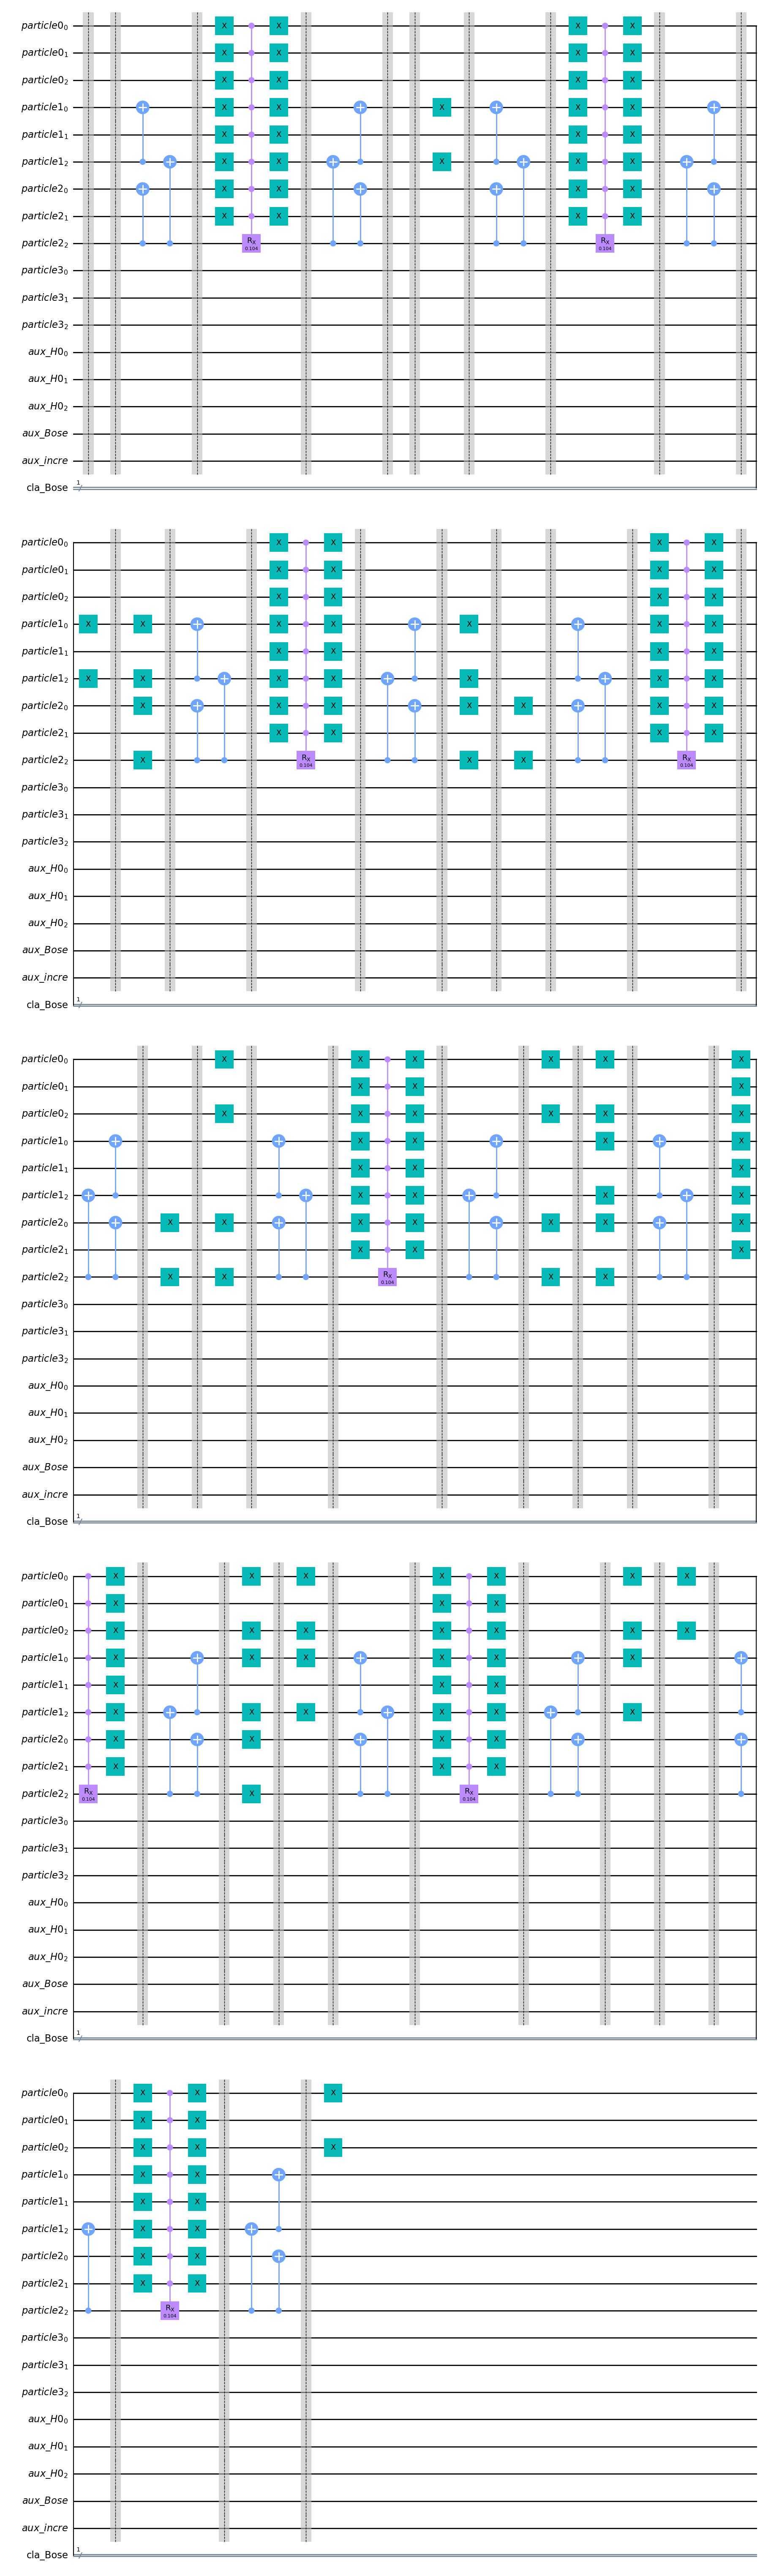

In [132]:
n = 4
M = 4
N_abs = 1
N = N_abs * d + d + 1

circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
ipos = 1
ireg = particle_regs[0]
jreg = particle_regs[1]
kreg = particle_regs[2]
two_hamming_list = ['00', '10']
three_hamming_list = ['000', '010', '011', '001', '101', '111', '110', '100']
# three_hamming_list = ['111']
intHamiltonianTwoIndices(circuit, ireg, jreg, kreg, ipos, three_hamming_list)
# int_gate.name = f'pos{ipos} intH'
# circuit.append(int_gate, qargs=ireg[:]+jreg[:]+kreg[:])

circuit.draw('mpl')

In [42]:
def interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list):
    delta = 1
    coupling_lambda = 0.1
    Delta = delta * coupling_lambda / 96
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg, kreg, lreg]

    int_circuit = QuantumCircuit(ireg, jreg, kreg, lreg)

    for ihamming in hamming_list:
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                            int_circuit.x(reg_list[istring][N-1])

        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        for xnum, xreg in enumerate(reg_list):
            if xnum != 3:
                int_circuit.cx(lreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N] + lreg[:N_abs + d])
        mcrx = RXGate(Delta * 100).control(4 * ireg.size - 1)
        mcrx.name = 'MultiCNOT'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:] + kreg[:] + lreg[:jreg.size-1] + [lreg[lreg.size-1]])
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N] + lreg[:N_abs + d])

        for xnum, xreg in enumerate(reg_list):
            if xnum != 3:
                int_circuit.cx(lreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                            int_circuit.x(reg_list[istring][N-1])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [ ]:
n = 4
M = 4
N_abs = 1
N = N_abs * d + d + 1
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
hamming_list = ['1000', '1100', '0100', '0110', '0010', '0000', '0001', '0101'] # 0 corresponds to vacuum state |Omega>^(i), 1 corresponds to |n>^(i)

ireg = particle_regs[0]
jreg = particle_regs[1]
kreg = particle_regs[2]
lreg = particle_regs[3]

ipos = 1
int_gate = interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list)
int_gate.name = f'pos{ipos} intH'
circuit.append(int_gate, qargs=particle_1D_list)

circuit.decompose().draw('mpl')

In [136]:
n = 4
M = 4
N_abs = 1
N = N_abs * d + d + 1
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
hamming_list = ['1000', '1100', '0100', '0110', '0010', '0000', '0001', '0101']

for ipos in range(2 ** (N_abs * d + d)):
    for inum, ireg in enumerate(particle_regs):
        for jnum, jreg in enumerate(particle_regs):
            for knum, kreg in enumerate(particle_regs):
                for lnum, lreg in enumerate(particle_regs):
                    if inum < jnum and jnum < knum and knum < lnum:
                        int_gate = interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list)
                        int_gate.name = f'pos{ipos} intH'
                        circuit.append(int_gate, qargs=particle_1D_list)

# circuit.draw('mpl')

In [137]:
ireg = particle_regs[0]
jreg = particle_regs[1]

if ireg == jreg:
    print('match!')
else: print('does not match...')

does not match...


In [27]:
# # # Show the state vector
# simulator = AerSimulator(method='statevector')
# circuit.save_statevector()
# circuit = transpile(circuit, backend=simulator)
# statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])
# print(statevector)

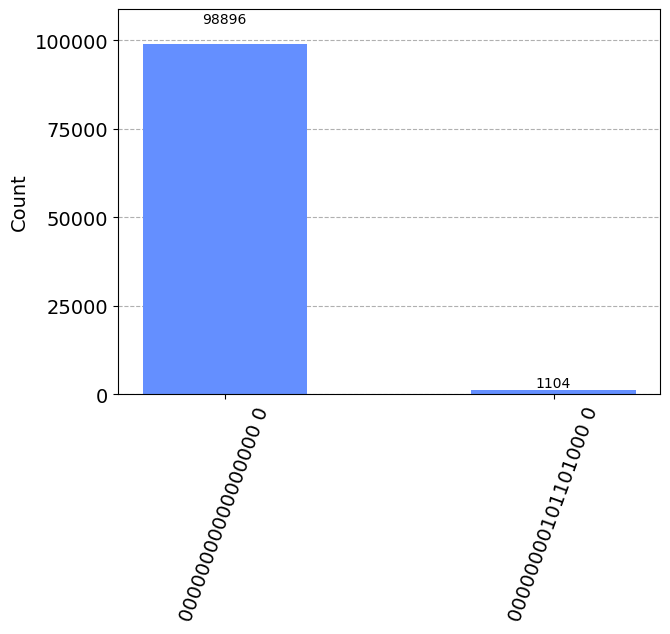

In [133]:
## how to measure and count
circuit.measure_all()
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=100000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

# plot y axis logarithmically
# log_data = {key: np.log10(value + 1) for key, value in counts.items()}
# # プロット
# plot_histogram(log_data, bar_labels=False)